## Approach
Our second attempt to improve default results from coursera_lab.ipynb:
- increase the batch size during training
  


----


## Step-by-step instructions 

### Step 1: Data preprocessing 


In [1]:
%%capture
!pip install tensorflow-cpu==2.16.2

# Suppress warnings and set environment variables
import os
import numpy as np
from tensorflow.keras.datasets import mnist
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Suppress all Python warnings
warnings.filterwarnings('ignore')

# Load the MNIST dataset
(x_train, _), (_, _) = mnist.load_data()

# Normalize the pixel values to the range [-1, 1]
x_train = x_train.astype('float32') / 127.5 - 1.
x_train = np.expand_dims(x_train, axis=-1)


2025-03-14 15:47:52.446584: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-14 15:47:52.489962: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Step 2: Building the model


In [7]:
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input 

# Define the generator model 
def build_generator(): 
    model = Sequential() 
    model.add(Dense(256, input_dim=100)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(BatchNormalization(momentum=0.8)) 
    model.add(Dense(512)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(BatchNormalization(momentum=0.8)) 
    model.add(Dense(1024)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(BatchNormalization(momentum=0.8)) 
    model.add(Dense(28 * 28 * 1, activation='tanh')) 
    model.add(Reshape((28, 28, 1))) 
    return model 

# Define the discriminator model 
def build_discriminator(): 
    model = Sequential() 
    model.add(Flatten(input_shape=(28, 28, 1))) 
    model.add(Dense(512)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(Dense(256)) 
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(Dense(1, activation='sigmoid')) 
    return model 

# Create the GAN by stacking the generator and the discriminator 
def build_gan(generator, discriminator): 
    discriminator.trainable = False 
    gan_input = Input(shape=(100,)) 
    generated_image = generator(gan_input) 
    gan_output = discriminator(generated_image) 
    gan = Model(gan_input, gan_output) 
    gan.compile(loss='binary_crossentropy', optimizer='adam') 
    return gan 


# Build the generator 
generator = build_generator()

# Build the GAN 
discriminator = build_discriminator() 
gan = build_gan(generator, discriminator) 

# Build and compile the discriminator
##important to build and compile after making GAN because it freezes discriminator's parameters 
discriminator = build_discriminator() 
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 


### Step 3: Training the GAN 

#### Objective: 
- Train the GAN on the MNIST dataset. 


In [ ]:
# Training parameters 

batch_size = 1024   #increase batch_size from 64 to 1024
epochs = 500
sample_interval = 10

# Adversarial ground truths 
real = np.ones((batch_size, 1)) 
fake = np.zeros((batch_size, 1)) 

# Training loop 
for epoch in range(epochs): 
    # Train the discriminator 
    idx = np.random.randint(0, x_train.shape[0], batch_size) 
    real_images = x_train[idx] 
    noise = np.random.normal(0, 1, (batch_size, 100)) 
    generated_images = generator.predict(noise) 
    d_loss_real = discriminator.train_on_batch(real_images, real) 
    d_loss_fake = discriminator.train_on_batch(generated_images, fake) 
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 

    noise = np.random.normal(0, 1, (batch_size, 100)) 
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1))) 

    # Print the progress 
    if epoch % sample_interval == 0: 
        print(f"{epoch} [D loss: {d_loss[0]}] [D accuracy: {100 * d_loss[1]}%] [G loss: {g_loss}]")


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
0 [D loss: 0.39515113830566406] [D accuracy: 75.2685546875%] [G loss: 0.6844687461853027]
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10 [D loss: 0.13048988580703735] [D accuracy: 94.03747320175171%] [G loss: 0.14646396040916443]
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━

### Step 4: Assessing the Quality of Generated Images 

### Objective: 
- Evaluate the performance of the trained GAN. 

### 1. Qualitative Assessment: Visual Inspection


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


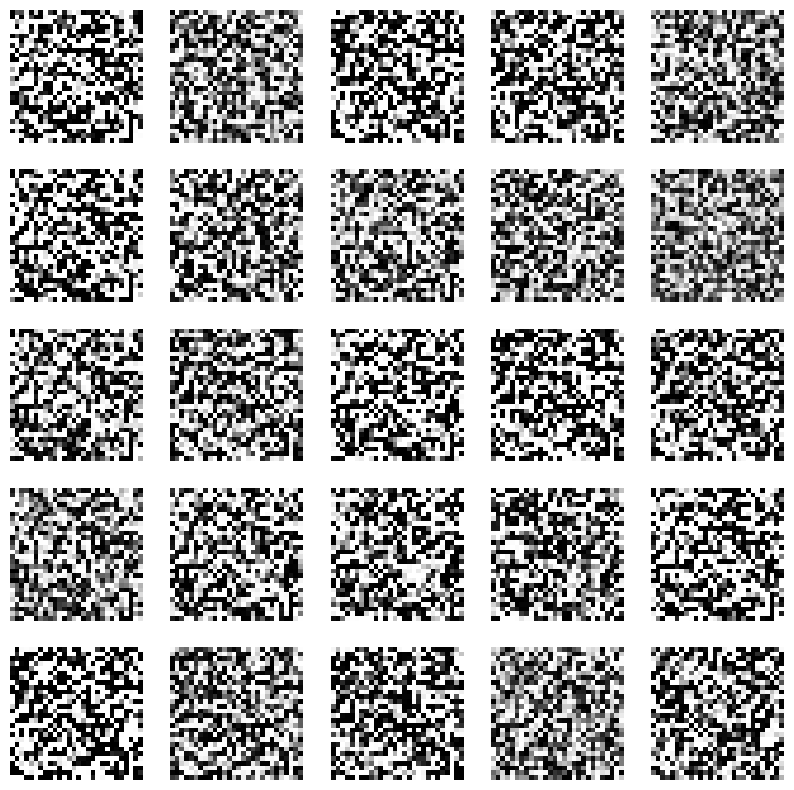

In [4]:
!pip install matplotlib
import matplotlib.pyplot as plt 

def sample_images(generator, epoch, num_images=25): 
    noise = np.random.normal(0, 1, (num_images, 100)) 
    generated_images = generator.predict(noise) 
    generated_images = 0.5 * generated_images + 0.5  # Rescale to [0, 1] 
    fig, axs = plt.subplots(5, 5, figsize=(10, 10)) 
    count = 0 

    for i in range(5): 
        for j in range(5): 
            axs[i, j].imshow(generated_images[count, :, :, 0], cmap='gray') 
            axs[i, j].axis('off') 
            count += 1 
    plt.show() 

# Sample images at the end of training 
sample_images(generator, epochs)



### 2. Quantitative Assessment: Metrics


In [5]:
# Calculate and print the discriminator accuracy on real vs. fake images
noise = np.random.normal(0, 1, (batch_size, 100))
generated_images = generator.predict(noise)

# Evaluate the discriminator on real images
real_images = x_train[np.random.randint(0, x_train.shape[0], batch_size)]
d_loss_real = discriminator.evaluate(real_images, np.ones((batch_size, 1)), verbose=0)

# Evaluate the discriminator on fake images
d_loss_fake = discriminator.evaluate(generated_images, np.zeros((batch_size, 1)), verbose=0)

print(f"Discriminator Accuracy on Real Images: {d_loss_real[1] * 100:.2f}%")
print(f"Discriminator Accuracy on Fake Images: {d_loss_fake[1] * 100:.2f}%")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Discriminator Accuracy on Real Images: 100.00%
Discriminator Accuracy on Fake Images: 100.00%


# Summary of results 

### GAN architecture still quickly gets stuck and provides poor results despite larger batch size.
